In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y, y_hat):
    y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
    return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

def compute_gradient(w, X, b, y):
    m = len(y)
    y_hat = sigmoid(np.dot(X, w) + b)
    error = y_hat - y
    gradient_w = np.dot(X.T, error) / m
    gradient_b = np.sum(error) / m
    return gradient_w, gradient_b

def predict_proba(w, X, b):
    return sigmoid(np.dot(X, w) + b)

def predict(w, X, b):
    return [int(p >= 0.5) for p in predict_proba(w, X, b)]

def train_lrgd(X, y, alpha, num_rounds):
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.DataFrame):
        y = y.values.flatten()
        
    n = X.shape[1]
    w = np.zeros(n)
    b = 0.0
    loss_history = []

    for _ in range(num_rounds):
        gradient_w, gradient_b = compute_gradient(w, X, b, y)
        w -= alpha * gradient_w
        b -= alpha * gradient_b
        y_hat = predict_proba(w, X, b)
        loss_history.append(compute_loss(y, y_hat))

    return w, b, loss_history

In [97]:
df = pd.read_csv("../data/features.csv")
df = df.loc[:1000]
X = df.drop(["CustomerId", "Exited"], axis=1).values
y = df["Exited"].values

/tmp/ipykernel_28940/1512322016.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


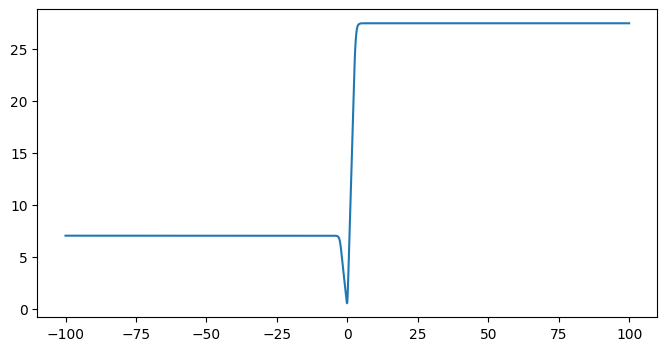

In [101]:
n_features = X.shape[1]
w = np.array([[i] * n_features for i in np.arange(-100.0, 100.1, 0.1)])
b = np.arange(-100.0, 100.1, 0.1)
loss = [compute_loss(y, predict_proba(w[i], X, b[i])) for i in range(len(w))]

fig = plt.figure(figsize=(8, 4))
plt.plot(b, loss)

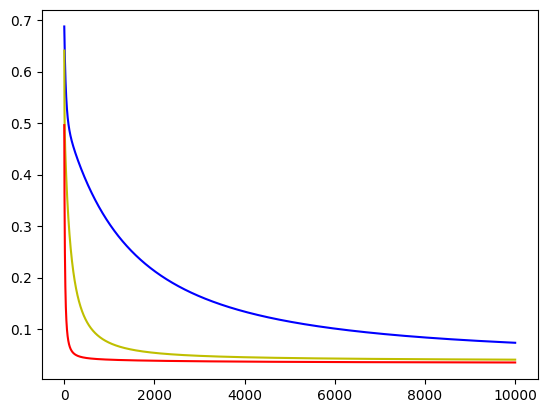

In [102]:
alphas = [0.01, 0.1, 1]
loss_log = {}
for alpha in alphas:
    w, b, loss = train_lrgd(X, y, alpha, 10000)
    loss_log[alpha] = loss

plt.plot(loss_log[0.01], "b")
plt.plot(loss_log[0.1], "y")
plt.plot(loss_log[1], "r")

In [109]:
from sklearn.metrics import f1_score

w, b, loss = train_lrgd(X, y, 0.1, 10000)
y_hat = predict(w, X, b)
f1_score(y, y_hat)

0.9757281553398058